In [2]:
pip install chart_studio

     ---------------------------------------- 0.0/64.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/64.4 kB ? eta -:--:--
     ------ --------------------------------- 10.2/64.4 kB ? eta -:--:--
     ------------------------ ------------- 41.0/64.4 kB 326.8 kB/s eta 0:00:01
     -------------------------------------- 64.4/64.4 kB 384.2 kB/s eta 0:00:00
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   ---------------------------------------- 0.1/15.6 MB 1.1 MB/s eta 0:00:15
   ---------------------------------------- 0.2/15.6 MB 2.4 MB/s eta 0:00:07
    --------------------------------------- 0.3/15.6 MB 2.3 MB/s eta 0:00:07
   - -------------------------------------- 0.5/15.6 MB 2.7 MB/s eta 0:00:06
   - -------------------------------------- 0.7/15.6 MB 2.9 MB/s eta 0:00:06
   -- ------------------------------------- 0.9/15.6 MB 3.1 MB/s eta 0:00:05
   -- ------------------------------------- 1.1/15.6 MB 3.4 MB/s eta 0:00:05
   --- ------

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as mse, r2_score
import matplotlib.pyplot as plt
import chart_studio.plotly as py
import plotly.graph_objs as go
from plotly.offline import plot
from plotly.offline import download_plotlyjs,init_notebook_mode,plot,iplot
init_notebook_mode(connected=True)
from sklearn.linear_model import Ridge,Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
from scipy import stats

In [3]:
tesla = pd.read_csv('TSLA.csv')
tesla['Date']=pd.to_datetime(tesla['Date'])
print(f' data is {tesla.Date.min()}{tesla.Date.max()}')
print(f' Total days is ={(tesla.Date.max() - tesla.Date.min()).days} days')

 data is 2010-06-29 00:00:002022-03-24 00:00:00
 Total days is =4286 days


In [5]:
correlation_matrix = tesla.corr()
print(correlation_matrix)

               Date      Open      High       Low     Close  Adj Close  \
Date       1.000000  0.666953  0.666909  0.667296  0.667145   0.667145   
Open       0.666953  1.000000  0.999726  0.999617  0.999247   0.999247   
High       0.666909  0.999726  1.000000  0.999595  0.999666   0.999666   
Low        0.667296  0.999617  0.999595  1.000000  0.999670   0.999670   
Close      0.667145  0.999247  0.999666  0.999670  1.000000   1.000000   
Adj Close  0.667145  0.999247  0.999666  0.999670  1.000000   1.000000   
Volume     0.430619  0.089750  0.093625  0.085906  0.090602   0.090602   

             Volume  
Date       0.430619  
Open       0.089750  
High       0.093625  
Low        0.085906  
Close      0.090602  
Adj Close  0.090602  
Volume     1.000000  


In [4]:
columns_to_drop = ['Open', 'High', 'Low', 'Adj Close']  # Column names as a list
tesla = tesla.drop(columns=columns_to_drop, axis=1)

In [5]:
tesla

,Date,Close,Volume
0,2010-06-29,4.778000,93831500
1,2010-06-30,4.766000,85935500
2,2010-07-01,4.392000,41094000
3,2010-07-02,3.840000,25699000
4,2010-07-06,3.222000,34334500
...,...,...,...
2951,2022-03-18,905.390015,33408500
2952,2022-03-21,921.159973,27327200
2953,2022-03-22,993.979980,35289500
2954,2022-03-23,999.109985,40225400


In [6]:
z_scores = stats.zscore(tesla['Close'])
outliers = np.where(np.abs(z_scores) > 3)  # Define a threshold (e.g., z-score > 3) for outliers
tesla_without_outliers = tesla.drop(outliers[0])

In [7]:
layout = go.Layout(
    title='Stock Prices of Tesla',
    xaxis=dict(
        title='Date',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#53a832'
        )
    ),
    yaxis=dict(
        title='Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#a832a8'
        )
    )
)

tesla_data = [{'x': tesla_without_outliers['Date'], 'y': tesla_without_outliers['Close']}]
plot = go.Figure(data=tesla_data, layout=layout)
iplot(plot)

In [8]:
tesla_without_outliers['MA_30'] = tesla_without_outliers['Close'].rolling(window=30).mean().shift(1)

# Updated Features and Target
X = tesla_without_outliers[['Close', 'MA_30']].dropna()
y = X['Close']
X = X.drop(columns=['Close'])
# Splitting the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)

# Scaling/Normalization (Example: StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [9]:
lr = LinearRegression()
lr.fit(X_train_scaled, y_train)

# Predict on the scaled test data
predictions = lr.predict(X_test_scaled)

# Calculate evaluation metrics using the scaled test features
r2_test = r2_score(y_test, predictions)
mse_test = mse(y_test, predictions)

# Print or store the evaluation metrics
print(f"R-squared on scaled test data: {r2_test}")
print(f"MSE on scaled test data: {mse_test}")

R-squared on scaled test data: 0.9828943359833439
MSE on scaled test data: 660.944681822647


In [10]:
trace0 = go.Scatter(
    x=X_train_scaled.T[0],
    y=y_train,
    mode='markers',
    name='Actual'
)

trace1 = go.Scatter(
    x=X_train_scaled.T[0],
    y=lr.predict(X_train_scaled),
    mode='lines',
    name='Predicted'
)
tesla_data=[trace0,trace1]
layout.xaxis.title.text='Day'
plot2=go.Figure(data=tesla_data,layout=layout)
iplot(plot2)

Ridge Regression - Mean Squared Error (MSE): 660.3183912790468
Ridge Regression - R-squared: 0.9829105447764702


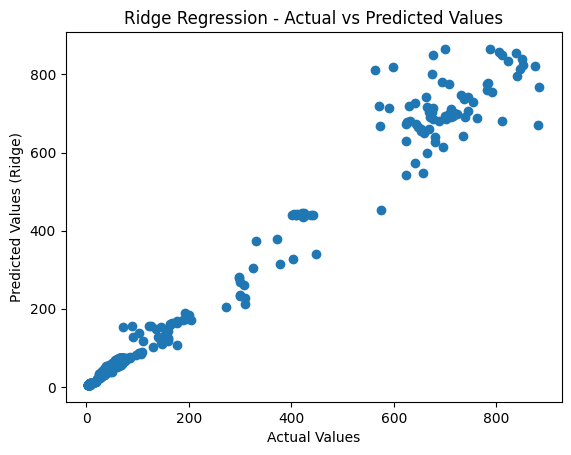

In [11]:
# Create and train Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # 'alpha' is the regularization strength parameter
ridge_model.fit(X_train_scaled, y_train)

# Predictions on testing data
y_pred_ridge = ridge_model.predict(X_test_scaled)

# Evaluate the Ridge model
mse_ridge = mse(y_test, y_pred_ridge)
r2_ridge = r2_score(y_test, y_pred_ridge)

# Print metrics for Ridge Regression
print(f'Ridge Regression - Mean Squared Error (MSE): {mse_ridge}')
print(f'Ridge Regression - R-squared: {r2_ridge}')

# Visualize the predictions vs actual values for Ridge Regression
plt.scatter(y_test, y_pred_ridge)
#plt.plot(y_test, y_pred_ridge, color='purple', linewidth=3, label='Prediction Line')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values (Ridge)')
plt.title('Ridge Regression - Actual vs Predicted Values')
plt.show()
      

In [12]:
y_test


251      5.492000
433      7.064000
1309    49.695999
517      6.670000
958     40.875999
          ...    
1809    69.917999
1076    51.914001
736     18.518000
1327    48.292000
295      4.942000
Name: Close, Length: 853, dtype: float64

In [13]:
from sklearn.neighbors import KNeighborsRegressor

# Assuming you've defined X_train_scaled, X_test_scaled, y_train, y_test previously

# Create a KNN model
knn = KNeighborsRegressor(n_neighbors=5)  # You can change the number of neighbors as needed

# Fit the KNN model
knn.fit(X_train_scaled, y_train)

# Make predictions
predictions = knn.predict(X_test_scaled)

# Evaluate the model (Example: R-squared and Mean Squared Error)
r2 = r2_score(y_test, predictions)
mean_squared_error  = mse(y_test, predictions)

print(f"R-squared: {r2}")
print(f"Mean Squared Error: {mean_squared_error }")

R-squared: 0.9852636556483577
Mean Squared Error: 569.3966875089543


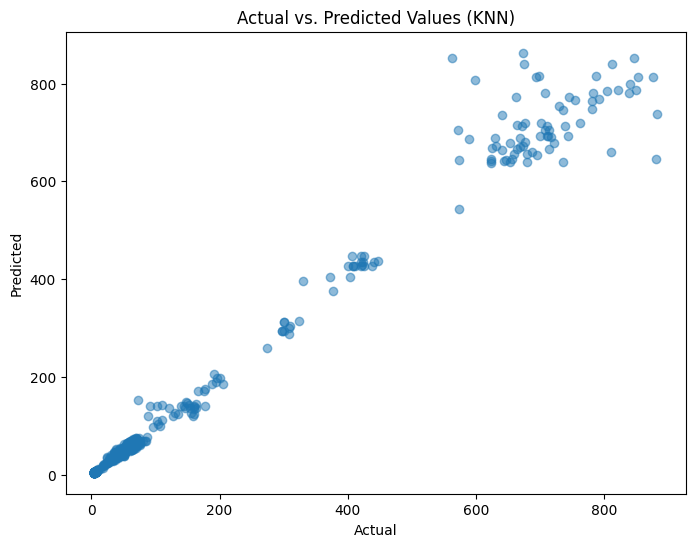

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs. Predicted Values (KNN)')
plt.show()